In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
data = pd.read_csv('data/2024-01_rws_filedata.csv', sep=';')
column_translation = {
    'tNLSitNummer': 'IncidentNumber',
    'DatumFileBegin': 'DateTrafficJamStart',
    'DatumFileEind': 'DateTrafficJamEnd',
    'TijdFileBegin': 'TimeTrafficJamStart',
    'TijdFileEind': 'TimeTrafficJamEnd',
    'FileZwaarte': 'TrafficJamSeverity',
    'GemLengte': 'AverageLength',
    'FileDuur': 'TrafficJamDuration',
    'HectometerKop': 'HectometerHead',
    'HectometerStaart': 'HectometerTail',
    'RouteLet': 'RouteLetter',
    'RouteNum': 'RouteNumber',
    'RouteOms': 'RouteDescription',
    'hectometreringsrichting': 'HectometerDirection',
    'VERKEERSKUNDIGWEGVAKVILD': 'TrafficSectionID',
    'TRAJECTVILD': 'TrajectoryID',
    'OorzaakGronddetail': 'CauseDetail',
    'OorzaakVerloop': 'CauseProgression',
    'OorzaakCodeVerloop': 'CauseProgressionCode',
    'OorzaakCode': 'CauseCode',
    'Oorzaak_1': 'Cause_1',
    'Oorzaak_2': 'Cause_2',
    'Oorzaak_3': 'Cause_3',
    'Oorzaak_4': 'Cause_4'
}

# Creating a new DataFrame with English column names
df_english = data.rename(columns=column_translation)
df_english['DateTimeStart'] = pd.to_datetime(df_english['DateTrafficJamStart'] + ' ' + df_english['TimeTrafficJamStart'])
df_english['DateTimeEnd'] = pd.to_datetime(df_english['DateTrafficJamEnd'] + ' ' + df_english['TimeTrafficJamEnd'])
df_english['Duration'] = (df_english['DateTimeEnd'] - df_english['DateTimeStart']).dt.total_seconds()/60
df_english['TimeTrafficJamStart'] = pd.to_datetime(df_english['TimeTrafficJamStart']).dt.hour

C:\Users\20210828\AppData\Local\Temp\ipykernel_16608\3417387453.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_english['TimeTrafficJamStart'] = pd.to_datetime(df_english['TimeTrafficJamStart']).dt.hour


array([[<Axes: title={'center': 'Duration'}>]], dtype=object)

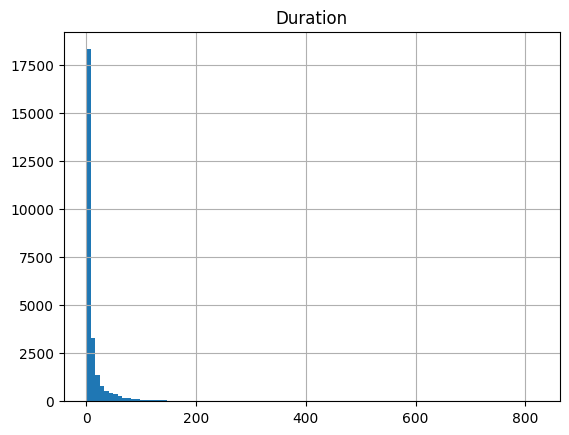

In [4]:
#Duration of the incident
df_english.hist('Duration', bins = 100)
# df_english['Duration'].plot.density()

In [5]:
#Distribution fitting
data = df_english['Duration'].values
x = np.linspace(0, data.max(), len(data))
#Fit exponential
loc, scale = stats.expon.fit(data)
fit_exp = stats.expon(loc = loc, scale = scale)

#Fit gamma
params = stats.gamma.fit(data)
fit_gamma = stats.gamma(a = params[0], loc = params[1], scale = params[2])

#Fit Erlang
params = stats.erlang.fit(data)
fit_erlang = stats.erlang(a = params[0], loc = params[1], scale = params[2])

#LogNormal
params = stats.lognorm.fit(data)
fit_lognormal = stats.lognorm(s = params[0], loc = params[1], scale = params[2])

#Kolmogorov-Smirnov test
stats.kstest(data, fit_exp.cdf)
stats.kstest(data, fit_gamma.cdf)
stats.kstest(data, fit_erlang.cdf)
stats.kstest(data, fit_lognormal.cdf)


C:\Users\20210828\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_optimize.py:640: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  fx = function(np.copy(x), *(wrapper_args + args))
C:\Users\20210828\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_optimize.py:640: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  fx = function(np.copy(x), *(wrapper_args + args))
C:\Users\20210828\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_optimize.py:640: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  fx = function(np.co

KstestResult(statistic=0.14008495011191946, pvalue=0.0, statistic_location=1.4666666666666666, statistic_sign=-1)

In [6]:
stats.lognorm.fit(data)

(1.2294425495153518, 0.09878316410683122, 5.082687545787541)

(-1.0, 50.0)

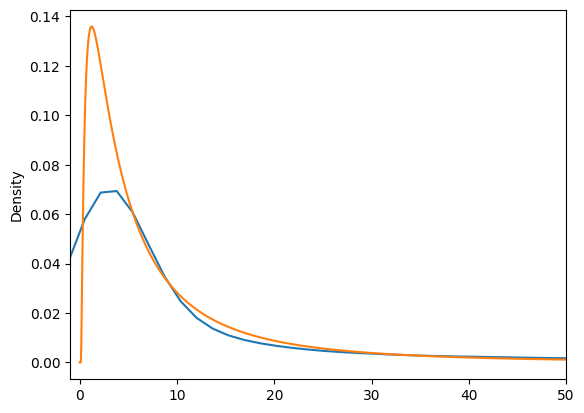

In [7]:
# plt.hist(data, bins = 1000)
ax = df_english['Duration'].plot.density()
ax.plot(x, fit_lognormal.pdf(x))
plt.xlim((-1,50))

In [8]:
params

(1.2294425495153518, 0.09878316410683122, 5.082687545787541)

array([[<Axes: title={'center': 'TimeTrafficJamStart'}>]], dtype=object)

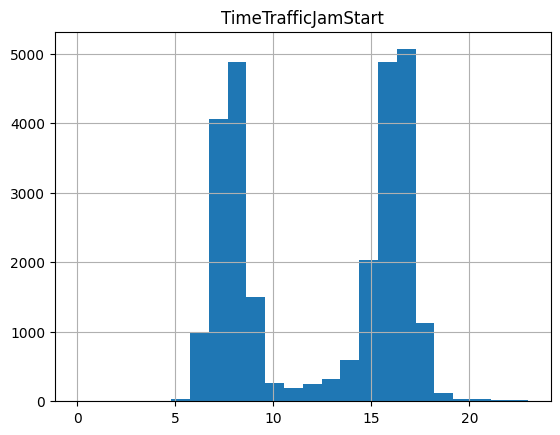

In [9]:
#Start time of the incident
df_english.hist('TimeTrafficJamStart', bins = 24)

In [10]:
#Number of incidents per day
events_per_day = df_english.groupby('DateTrafficJamStart').size()
events_per_day.describe()

count      31.000000
mean      852.774194
std       758.239747
min         6.000000
25%        94.000000
50%       930.000000
75%      1610.500000
max      2206.000000
dtype: float64

In [11]:
#Number of incidents per hour throughout a day
incidents_group_day = df_english.groupby(['DateTrafficJamStart', 'TimeTrafficJamStart']).size().reset_index(name='Number of accidents')
#All possible combinations of date and hour
full_range = pd.MultiIndex.from_product([df_english['DateTrafficJamStart'].unique(), range(24)], names=['DateTrafficJamStart', 'TimeTrafficJamStart']).to_frame(index=False)
traffic_jam_counts = full_range.merge(incidents_group_day, on=['DateTrafficJamStart', 'TimeTrafficJamStart'], how='left').fillna(0)
traffic_jam_counts.describe()

,TimeTrafficJamStart,Number of accidents
count,744.000000,744.000000
mean,11.500000,35.532258
std,6.926843,84.779766
min,0.000000,0.000000
25%,5.750000,0.000000
50%,11.500000,2.000000
75%,17.250000,15.000000
max,23.000000,484.000000


In [12]:
time_between_events = (df_english['DateTimeStart'][1:] - df_english['DateTimeStart'][:-1]).dt.total_seconds()

In [13]:
df_english

,IncidentNumber,DateTrafficJamStart,DateTrafficJamEnd,TimeTrafficJamStart,TimeTrafficJamEnd,TrafficJamSeverity,AverageLength,TrafficJamDuration,HectometerHead,HectometerTail,...,CauseProgression,CauseProgressionCode,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,DateTimeStart,DateTimeEnd,Duration
0,3908337,2024-01-17,2024-01-17,15,17:15:03,"339,422","3628,000","93,567","52,4","55,3",...,[Geen oorzaakcode opgegeven door VWM 94],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-17 15:41:29,2024-01-17 17:15:03,93.566667
1,3908338,2024-01-17,2024-01-17,15,15:46:01,"11,773","2597,000","4,533","208,6","210,8",...,[Geen oorzaakcode opgegeven door VWM 5],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-17 15:41:29,2024-01-17 15:46:01,4.533333
2,3908339,2024-01-17,2024-01-17,15,16:08:00,"90,428","3410,000","26,517","61,2","59,1",...,[Geen oorzaakcode opgegeven door VWM 27],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-17 15:41:29,2024-01-17 16:08:00,26.516667
3,3908340,2024-01-17,2024-01-17,15,15:43:00,"3,185","2100,000","1,517","41,8","43,9",...,[Geen oorzaakcode opgegeven door VWM 2],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-17 15:41:29,2024-01-17 15:43:00,1.516667
4,3908341,2024-01-17,2024-01-17,15,15:44:00,"5,915","3900,000","1,517","13,5","9,6",...,[Geen oorzaakcode opgegeven door VWM 2],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-17 15:42:29,2024-01-17 15:44:00,1.516667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,3921121,2024-01-25,2024-01-25,16,16:59:00,"211,715","3682,000","57,500","84,8","86,9",...,[Geen oorzaakcode opgegeven door VWM 58],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-25 16:01:30,2024-01-25 16:59:00,57.500000
26432,3921122,2024-01-25,2024-01-25,16,16:04:00,"6,267","2507,000","2,500","17,4","20,1",...,[Geen oorzaakcode opgegeven door VWM 2],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-25 16:01:30,2024-01-25 16:04:00,2.500000
26433,3921123,2024-01-25,2024-01-25,16,16:45:03,"130,425","2995,000","43,550","29,0","27,0",...,[Geen oorzaakcode opgegeven door VWM 44],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-25 16:01:30,2024-01-25 16:45:03,43.550000
26434,3921124,2024-01-25,2024-01-25,16,16:03:00,"4,350","2900,000","1,500","73,6","70,7",...,[Geen oorzaakcode opgegeven door VWM 2],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-01-25 16:01:30,2024-01-25 16:03:00,1.500000


In [104]:
time_between_events.max()

0.0

In [106]:
df_english['DateTimeStart'][20:30]

20   2024-01-17 17:09:31
21   2024-01-17 17:09:31
22   2024-01-17 17:09:31
23   2024-01-17 17:09:31
24   2024-01-17 17:09:31
25   2024-01-17 17:26:31
26   2024-01-17 17:26:31
27   2024-01-17 17:26:31
28   2024-01-17 17:26:31
29   2024-01-17 17:27:31
Name: DateTimeStart, dtype: datetime64[ns]